### Question 4: Explainable AI (20 Marks)

##### a. Explain the methodologies and provide and in depth comparion of the methodologies.

##### b. Impements an explainable AI feature for the model you developed.

In [ ]:
#install dependancies
!pip install shap

In [59]:
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np

import shap
shap.initjs()
print(shap.__version__)

0.48.0


##### Define the Model

In [28]:
# Define the model architecture.
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        #First Layer
        self.layer_1 = nn.Linear(input_size, 128)     # Input layer to 128 neurons
        self.activation_1 = nn.ReLU()       # ReLU activation function

        # Second Layer
        self.layer_2 = nn.Linear(128, 64)    # 128 neurons to 64 neurons
        self.activation_2 = nn.ReLU()       # Another ReLU

        # Second Layer
        self.layer_3 = nn.Linear(64, 32)    # 64 neurons to 32 neurons
        self.activation_3 = nn.ReLU()       # Another ReLU

         # Third and the final Layer
        self.layer_4 = nn.Linear(32, 1)     # Output layer to 1 neurons (classes)
        

    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation_1(x)

        x = self.layer_2(x)
        x= self.activation_2(x)

        x = self.layer_3(x)
        x= self.activation_3(x)

        x = self.layer_4(x)  # Final layer does not need activation for multi-class classification
        return x

##### Load the model and the feature scalars

In [29]:
# load the model
def load_model(model_path, input_size):

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    model = FullyConnectedNeuralNetwork(input_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    print("Model loaded successfully!")
    return model

In [30]:
# Get current directory
current_dir = os.path.abspath(".")

# model local file path
model_path = os.path.join(current_dir, 'model', 'optimized_model.pt')
loaded_model = load_model(model_path, input_size=41)

Model loaded successfully!


In [48]:
##### Load the X datasets
X_train_scaled = np.load(os.path.join(current_dir, 'model', 'X_train_scaled.npy'))
X_val_scaled = np.load(os.path.join(current_dir, 'model', 'X_val_scaled.npy'))
X_test_scaled = np.load(os.path.join(current_dir, 'model', 'X_test_scaled.npy'))

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(18000, 41)
(6000, 41)
(6000, 41)


In [49]:
# Use a subset of your training data as background
background = X_test_scaled[:100]  # Use 100 samples for background

# Convert to tensor
background_tensor = torch.tensor(background, dtype=torch.float32)

# Create DeepExplainer
explainer = shap.DeepExplainer(loaded_model, background_tensor)

# Calculate SHAP values
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
shap_values = explainer(X_test_scaled_tensor)

print(f"SHAP values shape: {np.shape(shap_values)}")

SHAP values shape: (6000, 41, 1)


In [50]:
feature_names = [
    "ExperienceYears", "Certifications", "PreviousCompanies", "Age", 
    "CompanySize", "CommuterSupport", "HealthInsurance", "FlexibleHours",
    "Gym", "Bonus", "StockOptions", "Retirement", "Gender_Female",
    "Gender_Male", "Gender_Non-binary", "RemoteOnsite_Hybrid",
    "RemoteOnsite_Onsite", "RemoteOnsite_Remote", "Industry_Consulting",
    "Industry_Finance", "Industry_Healthcare", "Industry_Retail",
    "Industry_Tech", "Education_Bachelors", "Education_Diploma",
    "Education_Masters", "Education_PhD", "Location_Australia",
    "Location_Germany", "Location_India", "Location_SriLanka",
    "Location_Sweden", "Location_UK", "Location_USA",
    "JobTitle_DataEngineer", "JobTitle_DataScientist",
    "JobTitle_FullstackDeveloper", "JobTitle_LeadEngineer",
    "JobTitle_SeniorSoftwareEngineer", "JobTitle_SoftwareArchitect",
    "JobTitle_SoftwareEngineer"
]

##### Global Explanation

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26772\2939800248.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values.squeeze(), X_test_scaled, feature_names=feature_names)


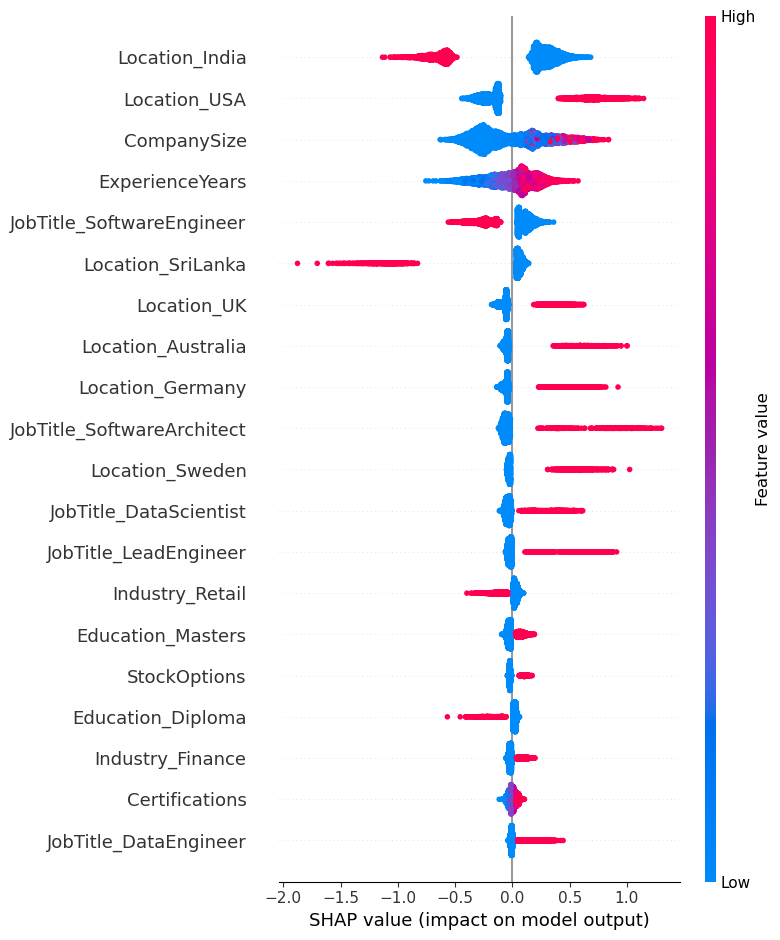

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26772\2939800248.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values.squeeze(), X_test_scaled, feature_names=feature_names, plot_type="bar")


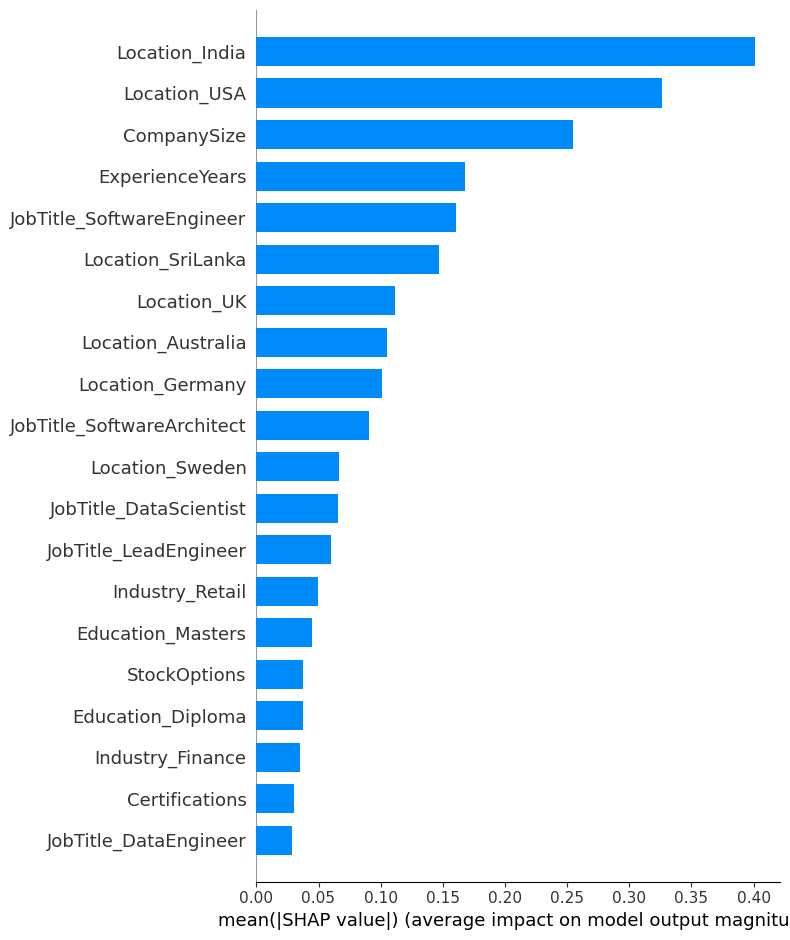

In [51]:
# Summary plot: shows feature importance and impact
shap.summary_plot(shap_values.values.squeeze(), X_test_scaled, feature_names=feature_names)

# Bar plot: shows mean absolute SHAP value for each feature
shap.summary_plot(shap_values.values.squeeze(), X_test_scaled, feature_names=feature_names, plot_type="bar")

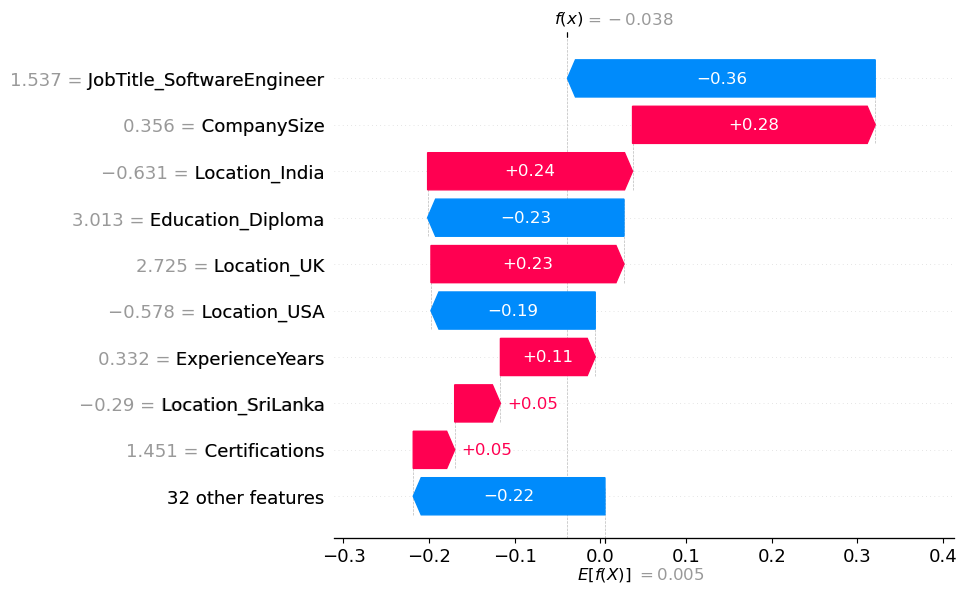

In [54]:
import shap

# For regression models, use shap_values directly
exp = shap.Explanation(
    values=shap_values.values[0].squeeze(),  # 1D array for one sample
    base_values=explainer.expected_value[0],  # scalar base value
    data=X_test_scaled[0],
    feature_names=feature_names
)

shap.plots.waterfall(exp)